In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import math
import time
# import func3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Writing the data generation:

In [2]:
def batchSeqGen(batchSize, prob, seqLength=None):
    if seqLength == None:
        seqLength = random.randint(3,100)
    batchX = torch.randn(batchSize, seqLength, 10) #implies batch_first=true
    batchY = torch.zeros(batchSize, seqLength)
    changePoints = []
    for i in range(batchSize):
        changePoint = -1
        ind = [0,0,0,0,0]
        offset = torch.zeros(5)
        if random.random() < prob:
            changePoint = random.randint(0,seqLength - 1) 
            ind = random.sample(range(10), 5)
            offset = 2*torch.rand(5) - 1
            for j in range(seqLength):
                if j >= changePoint:
                    batchY[i,j] = 1
                    c = 0
                    for k in ind:
                        batchX[i,j,k] += offset[c]
                        c += 1
        changePoints.append(changePoint)
            
    return batchX, batchY, changePoints     

The LSTM model itself:

In [6]:
class changeDetectLSTM(nn.Module):
    def __init__(self):
        super(changeDetectLSTM, self).__init__()
        hidden_layer_node_num = 60
        hidden_layer_num = 1
        self.lstm = nn.LSTM(10, hidden_layer_node_num, hidden_layer_num ,batch_first=True, bidirectional=True, dropout = 0.1)
        self.layernorm = nn.LayerNorm(hidden_layer_node_num * 2)
        self.linearClassify = nn.Linear(hidden_layer_node_num * 2,1)
    
    def forward(self, seq):
        # seq = torch.mul(seq, 10)
        seq, _ = self.lstm(seq)
        seq = self.layernorm(seq)
        seq = self.linearClassify(seq)
        
        return seq[:,:,0]

The training loop:

In [7]:
model = changeDetectLSTM()
model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr = 0.0002, weight_decay = 0.001)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
print("Hello")

x_test, y_test, _ = batchSeqGen(100, 1.0, 100)
x_test = x_test.to(device)
y_test = y_test.to(device)
for epoch in range(30):
    totalLoss = 0
    for i in range(2**7):
        x_batch, y_batch, _ = batchSeqGen(40,0.8)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad 
        output = model(x_batch)
        # print(output.shape)
        # print(y_batch[0])
#         print(output.shape)
#         print(y_batch.shape)
        # loss = torch.nn.CrossEntropyLoss()(output, y_batch)
        loss = torch.nn.BCEWithLogitsLoss()(output, y_batch)

        totalLoss += loss.item()
        loss.backward()
        optimizer.step()
            
    # print((epoch+1),"Test loss",torch.nn.CrossEntropyLoss()(model.forward(x_test), y_test).item(), "Training loss", totalLoss)
    print((epoch+1),"Test loss",torch.nn.BCEWithLogitsLoss()(model.forward(x_test), y_test).item(), "Training loss", totalLoss)


/common/home/anv39/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Hello
1 Test loss 0.6604498028755188 Training loss 86.07782930135727
2 Test loss 0.6623440384864807 Training loss 80.99106752872467
3 Test loss 0.5935699939727783 Training loss 82.72880691289902
4 Test loss 0.6143462657928467 Training loss 84.98013216257095
5 Test loss 0.5807298421859741 Training loss 76.2516240477562
6 Test loss 0.5727764964103699 Training loss 71.48073580861092
7 Test loss 0.4521388113498688 Training loss 65.63416972756386
8 Test loss 0.39696767926216125 Training loss 60.04919943213463
9 Test loss 0.6665244102478027 Training loss 61.23584249615669
10 Test loss 0.4485471546649933 Training loss 64.56369972229004
11 Test loss 0.5104808211326599 Training loss 55.2418449819088
12 Test loss 0.3390613794326782 Training loss 57.492817252874374
13 Test loss 0.3531624674797058 Training loss 54.05975830554962
14 Test loss 0.3031250834465027 Training loss 54.7963543087244
15 Test loss 0.4132019281387329 Training loss 53.1803944259882
16 Test loss 0.3286920189857483 Training loss

In [14]:
def error_present(modeled, T, seq):
    values = []
    for i in range(11):
        if i - 5 + T > 100:
            values.append(1.0)
        else:
            values.append(modeled[i - 5 + T].item())
    plt.scatter([i-5 for i in range(11)], values)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')
tensor([[0.0129, 0.0382, 0.0134, 0.0238, 0.0237, 0.0378, 0.0046, 0.0332, 0.0152,
         0.0127, 0.0116, 0.0134, 0.0432, 0.0145, 0.0332, 0.0081, 0.0136, 0.0146,
         0.0145, 0.0130, 0.0164, 0.0035, 0.0061, 0.0065, 0.0107, 0.0178, 0.0172,
         0.0283, 0.0240, 0.0106, 0.0142, 0.0023, 0.0030, 0.0119, 0.0259, 0.0189,
         0.0094, 0.0125, 0.0051, 0.0190, 0.0087, 0.0188, 0.0636, 0.0293, 0.0154,
         0.0148, 0.0164, 0.0179, 0.0129, 0.0339, 0.0067, 0.0296, 0.0947, 0.1293,
         0.3076, 0.0911, 0.0838, 0.0994, 

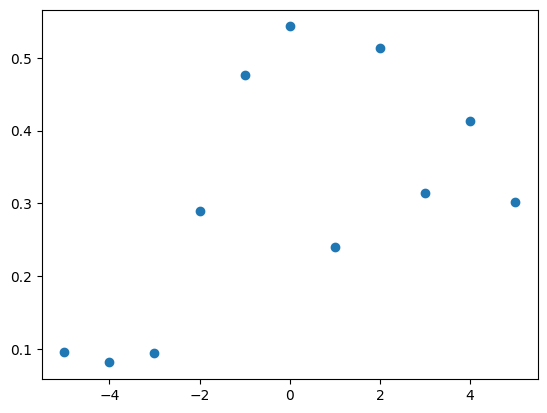

In [28]:

x, y, changePoints = batchSeqGen(1, 1.0, 100)
x = x.to(device)
y = y.to(device)
print(y)
print(nn.Sigmoid()(model.forward(x)))
print(torch.nn.BCEWithLogitsLoss()(model.forward(x), y).item())
modeled = nn.Sigmoid()(model(x))[0]
T = changePoints[0]
seq = y[0]
values = []
for i in range(11):
    if i - 5 + T >= 100:
        values.append(1.0)
    else:
        values.append(modeled[i - 5 + T].item())
plt.scatter([i-5 for i in range(11)], values)
plt.show()
# error_present(nn.Sigmoid()(model(x))[0], changePoints[0], y[0])
            